In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule
from pyro.infer import autoguide, SVI, Trace_ELBO

In [2]:
print(torch.__version__)
print(pyro.__version__)

1.3.0.post2
1.0.0


In [3]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def plot_obj(obj_function):

    steps = 1000
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = obj_function(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(steps, steps)
    plt.contour(
        X1_mesh.detach().numpy(), 
        X2_mesh.detach().numpy(), 
        Z_mesh.detach().numpy(), strides)
    
    plt.colorbar()

In [4]:
def expected_improvement(model, x):
    """ Brooks' implementation of expected improvement (EI). """
    
    y_min = model.y.min()
    mu, variance = model(x)
    sigma = variance.sqrt()
    delta = y_min - mu
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

def acquisition_func(model, x):
    """ Defines acquisition function. """

    return expected_improvement(model, x)

In [5]:
const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

# Creating constraints
constr = [
    constraints.interval(const_x1_min, const_x1_max),
    constraints.interval(const_x2_min, const_x2_max)
]

def branin_hoo(x):
    """ Compute Branin-Hoo function for fixed constants """
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    x1 = x[...,0]
    x2 = x[...,1]
    return a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*torch.cos(x1) + s

# Checking LMs
branin_hoo_lms = torch.stack(
    (torch.tensor([-math.pi, math.pi, 9.42478]), 
     torch.tensor([12.275, 2.275, 2.475])), dim=1)

assert np.allclose(branin_hoo(branin_hoo_lms).numpy(),
        np.array([0.397887, 0.397887, 0.397887], dtype=np.float32), rtol=1e-6)

In [6]:
set_random_seed(555)

# Training points
N_train = 10
X_train = torch.rand(N_train, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])
y_train = branin_hoo(X_train)

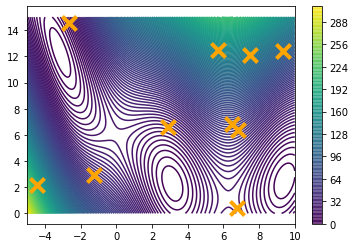

In [7]:
# Initial points
plot_obj(branin_hoo)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);

In [8]:
class GPWrappedModel(PyroModule):

    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        # Define GP (to be used for residual)
        self.kernel = gp.kernels.Matern52(input_dim=X.shape[1], lengthscale=100*torch.ones(X.shape[1]))
        self.gp = gp.models.GPRegression(X, y, self.kernel) 
        self.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([2]).to_event())
        self.gp.kernel.variance = PyroSample(dist.Uniform(0, 200))
        self.gp.noise = PyroSample(dist.Uniform(0, 1))

    @pyro.nn.pyro_method
    def model(self):
        return self.gp.model()
        
    def forward(self, X):
        mu, sigma = self.gp(X)
        
        # sample value of y
        pyro.sample('y', dist.Normal(mu, sigma))
        return mu, sigma

pyro.clear_param_store()

# Define the semiparametric model, and use an appropriate autoguide
gpwrapped = GPWrappedModel(X_train, y_train,)
guide = autoguide.AutoMultivariateNormal(gpwrapped.model)

# Check:
guide()

{'gp.kernel.lengthscale': tensor([8.0629, 8.3573], grad_fn=<ExpandBackward>),
 'gp.kernel.variance': tensor(78.7598, grad_fn=<ExpandBackward>),
 'gp.noise': tensor(0.3015, grad_fn=<ExpandBackward>)}

In [9]:
N_test = 2
X_test = torch.rand(N_test, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])

for i in range(3):
    print(gpwrapped(X_test))

(tensor([20.6580, 36.6404], grad_fn=<AddBackward0>), tensor([ 5.2666, 26.5930], grad_fn=<ExpandBackward>))
(tensor([20.6580, 36.6404], grad_fn=<AddBackward0>), tensor([ 5.2666, 26.5930], grad_fn=<ExpandBackward>))
(tensor([20.6580, 36.6404], grad_fn=<AddBackward0>), tensor([ 5.2666, 26.5930], grad_fn=<ExpandBackward>))


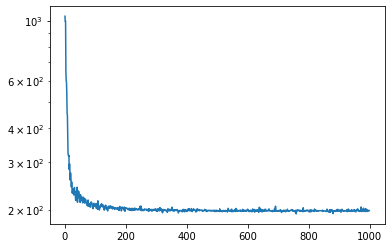

In [10]:
opt = pyro.optim.Adam({'lr': 0.1})
loss = Trace_ELBO()
svi = SVI(gpwrapped.model, guide, opt, loss)

losses = []
for _ in range(1000):
    losses.append(svi.step())

plt.semilogy(losses)

In [11]:
N_test = 2
X_test = torch.rand(N_test, 2)*15 + torch.FloatTensor([const_x1_min, const_x2_min])

for i in range(3):
    print(gpwrapped(X_test))

(tensor([104.2110, 171.7180], grad_fn=<AddBackward0>), tensor([36.6652,  2.1627], grad_fn=<ExpandBackward>))
(tensor([104.2110, 171.7180], grad_fn=<AddBackward0>), tensor([36.6652,  2.1627], grad_fn=<ExpandBackward>))
(tensor([104.2110, 171.7180], grad_fn=<AddBackward0>), tensor([36.6652,  2.1627], grad_fn=<ExpandBackward>))


In [12]:
sorted(list(gpwrapped.named_pyro_params()))

[('gp.noise_map', tensor(0.5115, grad_fn=<AddBackward0>)),
 ('kernel.lengthscale_map', tensor([5.7069, 9.8566], grad_fn=<AddBackward0>)),
 ('kernel.variance_map', tensor(166.6350, grad_fn=<AddBackward0>))]

**Comment:** It seems that at the test time it is not using guide distributions but rather fixed MAP values.

In [13]:
ps = pyro.get_param_store()
sorted(list(ps.named_parameters()))

[('AutoMultivariateNormal.loc', Parameter containing:
  tensor([-1.5446, -0.9657,  5.2836,  0.5973], requires_grad=True)),
 ('AutoMultivariateNormal.scale_tril', Parameter containing:
  tensor([[-2.5392,  0.0000,  0.0000,  0.0000],
          [-0.0394, -1.5549,  0.0000,  0.0000],
          [ 0.0441,  0.0133, -0.4682,  0.0000],
          [-0.0198, -0.0881,  0.0062,  0.4702]], requires_grad=True)),
 ('gp.kernel.lengthscale_map', Parameter containing:
  tensor([-0.4876,  0.6504], requires_grad=True)),
 ('gp.kernel.variance_map', Parameter containing:
  tensor(1.6083, requires_grad=True)),
 ('gp.noise_map', Parameter containing:
  tensor(0.0459, requires_grad=True))]

**Comment:** However, it seems that autoguides parameters are registered with pyro but are not used when **forward** is called.

In [14]:
predictive = pyro.infer.Predictive(gpwrapped, guide=guide, num_samples=3)

In [15]:
predictive(X_test)

{'gp.kernel.lengthscale': tensor([[2.7226, 4.9915],
         [2.3794, 2.7788],
         [2.5296, 3.7355]], grad_fn=<AsStridedBackward>),
 'gp.kernel.variance': tensor([199.0603, 199.1135, 199.6160], grad_fn=<AsStridedBackward>),
 'gp.noise': tensor([0.5794, 0.2056, 0.2536], grad_fn=<AsStridedBackward>),
 'y': tensor([[ 146.1715,  161.3231],
         [-127.5602,  185.7186],
         [-106.5952,  185.8727]], grad_fn=<AsStridedBackward>)}

**Comment:** It seems that predictive does the trick as in the **GP_autoguide** notebook.

**Question:** Does it mean that when using autoguides such as *AutoMultivariateNormal* GPR model parameters (even when it is wrapped with PyroModule) are not registered with the model but rather in the general pyro parameters store? 

## Trying to find a way how to use semi parametric model with autoguides.

In [16]:
normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

In [17]:
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        self.alpha = PyroSample(dist.Uniform(0, 20))
        self.beta = PyroSample(dist.Uniform(0, 20))
        self.gamma = PyroSample(dist.Uniform(0, 20))
        
    def forward(self, X):
        x1 = X[...,0]
        x2 = X[...,1]
        return self.alpha*torch.cos(x1) + self.beta*torch.pow(x1, 4) + torch.pow(x2, 2) + self.gamma

In [18]:
class SemiParametricModel(PyroModule):

    def __init__(self, X, y, parametric_mean, kernel):
        """ Defines a semi-parametric model, where the `parametric_mean` is a `PyroModule` """
        super().__init__()
                
        self.X = X
        self.y = y
        
        self.parametric_mean = parametric_mean
        
        self.kernel = kernel
        self.gp = gp.models.GPRegression(X, y, self.kernel)

    @pyro.nn.pyro_method
    def model(self):
        # Model definition code: explicitly subtract out the parametric mean, then call gp.model
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        
        # reset "data" of GP to reflect mean estimate
        self.gp.set_data(self.X, self.y - self.parametric_mean(self.X))
        
        # sample mu, sigma
        mu, sigma = self.gp(X)
        
        # sample value of y
        y_hat = mu + self.parametric_mean(X)
        pyro.sample('y', dist.Normal(y_hat, sigma))
        
        # compute expected improvement
        y_min = self.y.min()
        delta = y_min - mu
        EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
        
        pyro.sample('EI', dist.Delta(-EI))
        
        # return the mean, in case we want to ignore the GP noise for some reason later
        return y_hat

In [19]:
set_random_seed(123)
pyro.clear_param_store()

kernel = gp.kernels.Matern52(input_dim=X_train.shape[1], lengthscale=100*torch.ones(X_train.shape[1]))
semiparametric = SemiParametricModel(X_train, y_train, ParametricMeanFn(), kernel)

# Set GP priors
semiparametric.gp.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(3, 1).expand([2]).to_event())
semiparametric.gp.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(5, 2))
semiparametric.gp.noise = pyro.nn.PyroSample(dist.LogNormal(0, 1))

# Autoguide
guide = autoguide.AutoMultivariateNormal(semiparametric.model)

# Check:
guide()

{'parametric_mean.alpha': tensor(7.7682, grad_fn=<ExpandBackward>),
 'parametric_mean.beta': tensor(14.8879, grad_fn=<ExpandBackward>),
 'parametric_mean.gamma': tensor(10.7565, grad_fn=<ExpandBackward>),
 'gp.kernel.lengthscale': tensor([14.1555, 20.0070], grad_fn=<ExpandBackward>),
 'gp.kernel.variance': tensor(110.5244, grad_fn=<ExpandBackward>),
 'gp.noise': tensor(1.6629, grad_fn=<ExpandBackward>)}

In [20]:
# Optimizer
optimizer = pyro.optim.Adam({"lr":0.01})
loss = Trace_ELBO()
svi = SVI(semiparametric.model, guide, optimizer, loss)

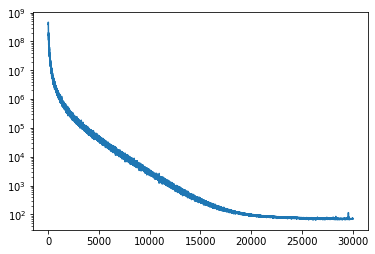

In [21]:
# do gradient steps
losses = []
for _ in range(30000):
    losses.append(svi.step())
    
plt.semilogy(losses);

#### num_samples = 1

In [22]:
predictive = pyro.infer.Predictive(semiparametric, guide=guide, num_samples=1, return_sites=('y', 'EI'))

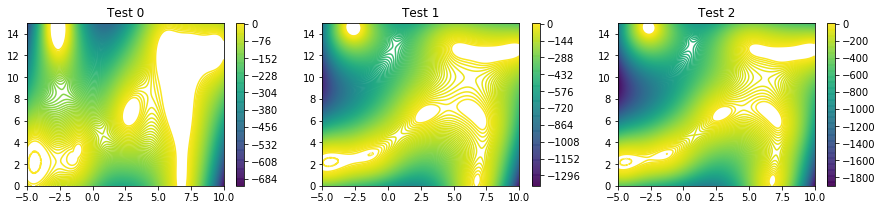

In [23]:
plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: predictive(X)['EI'].mean(0))

#### num_samples = 17

In [24]:
predictive = pyro.infer.Predictive(semiparametric, guide=guide, num_samples=17, return_sites=('y', 'EI'))

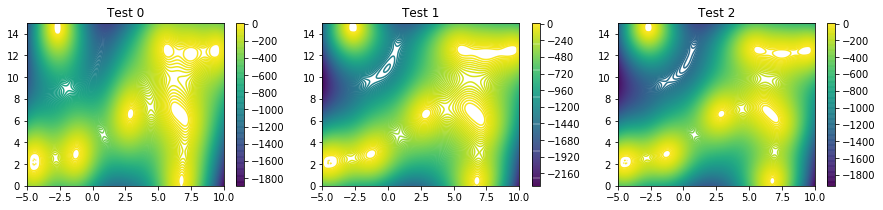

In [25]:
plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: predictive(X)['EI'].mean(0))